In [1]:
# Dependencies 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
import multiprocessing as mp

In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'

# Our color code for calls
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (0/255.0, 0/255.0, 0/255.0)}

# Call names are in alphabetical order (to check...)

callNames = ['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'So', 'Te', 'Th', 'Wh']

In [3]:
# First load the data

numUnits = [1, 2, 3, 5, 10, 20]
argList = []
pcc = []
confMat = []
selH = []

for nUnit in numUnits:
    inPath = rootPath+ dataPath + 'HerminaDataBase%dGoodUnitPCPerZone.pkl' % nUnit
    fileIn = open(inPath,"rb")
    argList.append(pk.load(fileIn))
    confMat.append(pk.load(fileIn))
    pcc.append(pk.load(fileIn))
    selH.append(pk.load(fileIn))
    zoneUnique = pk.load(fileIn)
    fileIn.close()


In [4]:
def info_matrix(conf_matrix):

# Calculates the mutual information from a confusion matrix.
# This code assumes that the rows are the actual categories and that they are equally probable
# This mutual information is not corrected for low probabilities.

    ncat = conf_matrix.shape[0]
    prob_matrix = np.copy(conf_matrix)

    for i in range(ncat):
        if (np.sum(conf_matrix[i,:]) < 0.9999 or np.sum(conf_matrix[i,:]) >  1.0001):
            print('Error: Row', i, 'does not sum to 1')
            return 0.0
    
    prob_matrix /= ncat

        

    # Check for sum = 1
    sump = np.sum(prob_matrix)
    if ( sump < 0.9999 or sump > 1.0001):
        print('Error in info_matrix: input matrix sums to %f' % sump)
        return 0.0


    prob_matrix_for_entropy = np.copy(prob_matrix)
    prob_matrix_for_entropy[prob_matrix ==0] = 1    # Set 0 to 1 to insure that xlogx goes to zero as x goes to zero
    tot_ent = np.sum(-prob_matrix_for_entropy*np.log2(prob_matrix_for_entropy))

    row_prob = np.sum(prob_matrix, axis=0)
    row_prob[row_prob == 0] = 1  # Set 0 to 1 to insure that xlogx goes to zero as x goes to zero
    row_ent = np.sum(-row_prob*np.log2(row_prob))

    col_prob = np.sum(prob_matrix, axis=1)
    col_prob[col_prob == 0] = 1  # Set 0 to 1 to insure that xlogx goes to zero as x goes to zero
    col_ent = np.sum(-col_prob*np.log2(col_prob));

    mi = row_ent + col_ent - tot_ent;

    return mi

In [5]:
# Calculate values to plot - take the mean and the top 5%


topPercent = 5.0
infoMean = np.zeros((len(numUnits), len(zoneUnique)))
pccMean = np.zeros((len(numUnits), len(zoneUnique)))
pccMax = np.zeros((len(numUnits), len(zoneUnique)))
argMax0 = []
argMax1 = []
for i, nUnit in enumerate(numUnits):
    for j, zone in enumerate(zoneUnique):

        # Mean values
    
        infoMean[i][j] = (info_matrix(confMat[i][j]))
        pccMean[i][j] = np.mean(pcc[i][j])

        # Max values (averaged over the topPercent)
        indSort = np.argsort(pcc[i][j])
        ls = len(indSort)
        ns = int(ls*topPercent/100.0)
        indGood = indSort[-ns:-1]
        pccMax[i][j] = np.mean(pcc[i][j][indGood])
        if j == 0:
            argMax0.append(indGood)
        elif j == 1:
            argMax1.append(indGood)

      

/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
# Load up data base to recalculate max values or load previous data (see below)

# Load the data base
outPath = rootPath+dataPath+'HerminaDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

/Users/frederictheunissen/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
pccNorm = []
rate = []
for i, nUnit in enumerate(numUnits):
    pccNormUnit = []
    rateUnit = []
    for j, zone in enumerate(zoneUnique):
        # Number of ensembles
        nEn = len(argList[i][j+1])  # ther first one was the "Border" that was skipped
        nSpikes = np.zeros(nEn)
        for k, unitList in enumerate(argList[i][j+1]):
            ensembleRate = 0
            for l, unit in enumerate(unitList):
            
                # Calculate the average response:
                unitIndex = dfDataBase.index[dfDataBase['site']+'_'+ dfDataBase['unit'] == unit]
                rvals = dfDataBase['R'][unitIndex].array
                rMean = np.mean(rvals)
                ensembleRate += rMean
            nSpikes[k] = ensembleRate
        pccNormUnit.append(pcc[i][j]/nSpikes)
        rateUnit.append(nSpikes)
    pccNorm.append(pccNormUnit)
    rate.append(rateUnit)
 

In [6]:
# Read previous calculation
inPath = rootPath+dataPath+'pccUnitRateArea.pkl'
fileIn = open(inPath,"rb")
argList = pk.load(fileIn)
pcc = pk.load(fileIn)
selH = pk.load(fileIn)
rate = pk.load(fileIn)
pccNorm = pk.load(fileIn)


fileIn.close()

L-CML
Average Rate 57.72497337298516
Average PCC 44.02481977718619
Average Eff 0.8129135098572344 0.8129135098572344
Avg pCC/ Avg Rate 0.7626650512720629


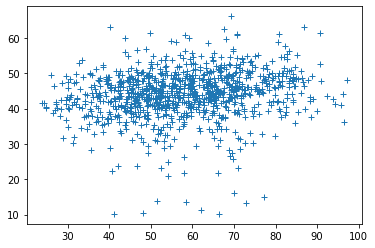

In [7]:
plt.plot(rate[5][0],pcc[5][0], '+')
print(zoneUnique[0])
print('Average Rate', np.mean(rate[5][0]))
print('Average PCC', np.mean(pcc[5][0]))
print('Average Eff', np.mean(pcc[5][0]/rate[5][0]), np.mean(pccNorm[5][0]))
print('Avg pCC/ Avg Rate', np.mean(pcc[5][0])/np.mean(rate[5][0]))

NCM-CMM
Average Rate 57.84232899365982
Average PCC 38.674254761126434
Average Eff 0.6786883821666377 0.6786883821666377
Avg pCC/ Avg Rate 0.6686151030565449


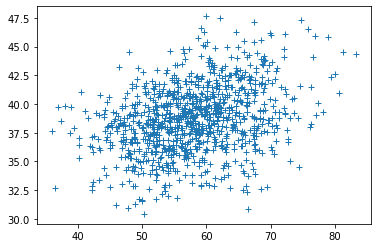

In [8]:
plt.plot(rate[5][1], pcc[5][1], '+')
print(zoneUnique[1])
print('Average Rate', np.mean(rate[5][1]))
print('Average PCC', np.mean(pcc[5][1]))
print('Average Eff', np.mean(pcc[5][1]/rate[5][1]), np.mean(pccNorm[5][1]))
print('Avg pCC/ Avg Rate', np.mean(pcc[5][1])/np.mean(rate[5][1]))

In [9]:
breakflg = False
unitNumber = np.zeros((len(numUnits), len(zoneUnique)))
for i, nUnit in enumerate(numUnits):

    for j, zone in enumerate(zoneUnique):
        # Number of ensembles
        nEn = len(argList[i][j+1])  # Note the plus one here to to skip the area that was "Border"
        unitNumber[i][j] = np.unique(argList[i][j+1]).shape[0]
        print(i, j, 'nEn', nEn, 'pcc',pcc[i][j].shape[0], 'units', unitNumber[i][j] )

0 0 nEn 56 pcc 56 units 56.0
0 1 nEn 38 pcc 38 units 38.0
1 0 nEn 1001 pcc 1001 units 56.0
1 1 nEn 703 pcc 703 units 38.0
2 0 nEn 1001 pcc 1001 units 56.0
2 1 nEn 1001 pcc 1001 units 38.0
3 0 nEn 1001 pcc 1001 units 56.0
3 1 nEn 1001 pcc 1001 units 38.0
4 0 nEn 1001 pcc 1001 units 56.0
4 1 nEn 1001 pcc 1001 units 38.0
5 0 nEn 1001 pcc 1001 units 56.0
5 1 nEn 1001 pcc 1001 units 38.0


In [10]:
# Calculate the Mean and Max of the pcc normalized by Rate
topPercent = 5
pccNormMean = np.zeros((len(numUnits), len(zoneUnique)))
pccNormMax = np.zeros((len(numUnits), len(zoneUnique)))
pccNormSD = np.zeros((len(numUnits), len(zoneUnique)))
for i, nUnit in enumerate(numUnits):
    for j, zone in enumerate(zoneUnique):

        pccNormMean[i][j] = np.mean(pccNorm[i][j])
        
        fac = np.sqrt(unitNumber[i][j]/(unitNumber[i][j]-nUnit))
        pccNormSD[i][j] =  np.std(pccNorm[i][j])*fac
                                  
        # Max values (averaged over the topPercent)
        indSort = np.argsort(pccNorm[i][j])
        ls = len(indSort)
        ns = int(ls*topPercent/100.0)
        indGood = indSort[-ns-1:-1]
        pccNormMax[i][j] = np.mean(pccNorm[i][j][indGood])

In [11]:
# Calculate the Mean and Max of the pcc
pccMean = np.zeros((len(numUnits), len(zoneUnique)))
pccMax = np.zeros((len(numUnits), len(zoneUnique)))
pccSD = np.zeros((len(numUnits), len(zoneUnique)))

for i, nUnit in enumerate(numUnits):
    for j, zone in enumerate(zoneUnique):

        pccMean[i][j] = np.mean(pcc[i][j])
        
        fac = np.sqrt(unitNumber[i][j]/(unitNumber[i][j]-nUnit))
        pccSD[i][j] =  np.std(pcc[i][j])*fac
        
        # Max values (averaged over the topPercent)
        indSort = np.argsort(pcc[i][j])
        ls = len(indSort)
        ns = int(ls*topPercent/100.0)
        indGood = indSort[-ns-1:-1]
        pccMax[i][j] = np.mean(pcc[i][j][indGood])

In [12]:
# Calculate the average rate
rateMean = np.zeros((len(numUnits), len(zoneUnique)))
rateMax = np.zeros((len(numUnits), len(zoneUnique)))
rateMin = np.zeros((len(numUnits), len(zoneUnique)))
rateSD = np.zeros((len(numUnits), len(zoneUnique)))

for i, nUnit in enumerate(numUnits):
    for j, zone in enumerate(zoneUnique):

        rateMean[i][j] = np.mean(rate[i][j])
        
        fac = np.sqrt(unitNumber[i][j]/(unitNumber[i][j]-nUnit))
        rateSD[i][j] =  np.std(rate[i][j])*fac
        
        # Max values (averaged over the topPercent)
        indSort = np.argsort(rate[i][j])
        ls = len(indSort)
        ns = int(ls*topPercent/100.0)
        indGood = indSort[-ns-1:-1]
        rateMax[i][j] = np.mean(rate[i][j][indGood])
        indGood = indSort[0:ns]
        rateMin[i][j] = np.mean(rate[i][j][indGood])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


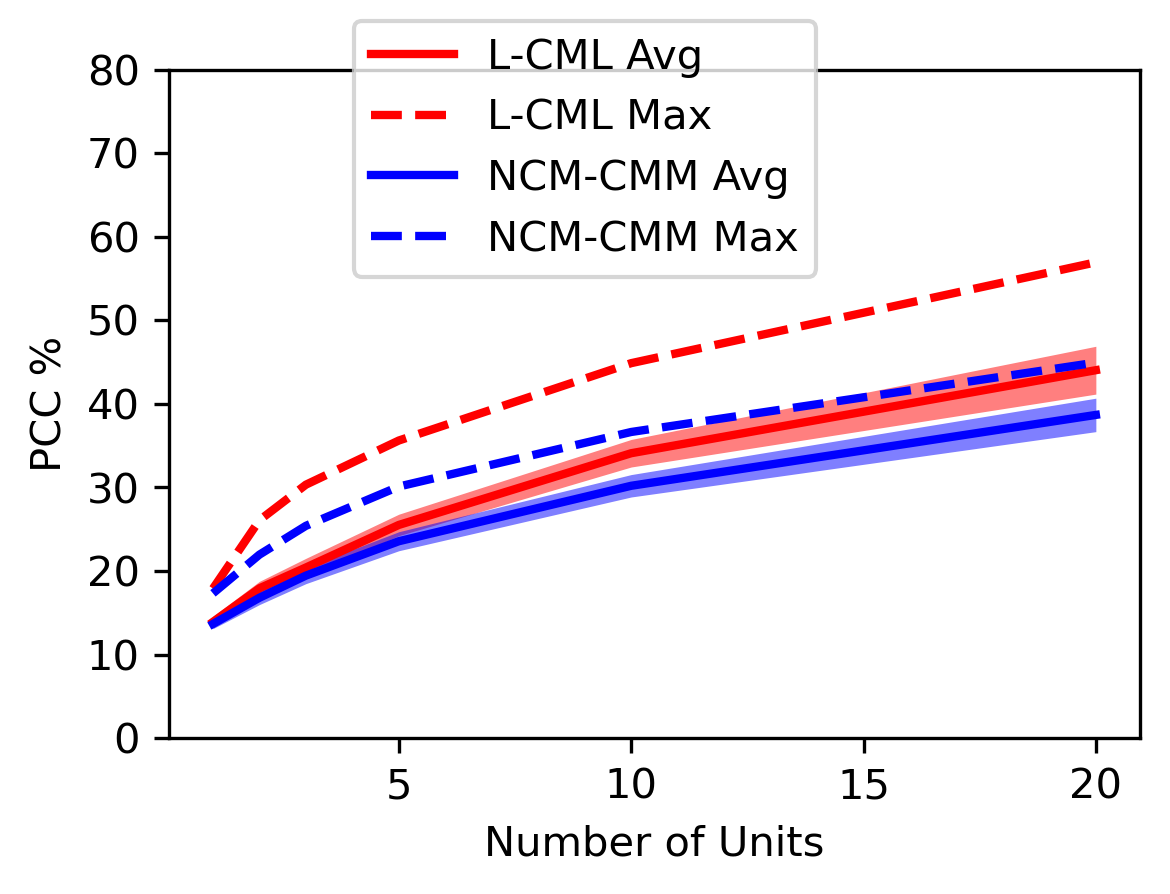

In [13]:
# Make plot of mean values
fig, ax1 = plt.subplots(figsize=(4, 3), dpi =300)
colorName = ['red', 'blue']

ax1.set_xlabel('Number of Units')
ax1.set_ylabel('PCC %')

for izone, zone in enumerate(zoneUnique):
    ax1.plot(numUnits, pccMean[:,izone], color=colorName[izone], linestyle='-', linewidth=2, label=zone +' Avg')
    df= np.zeros(len(numUnits))

    ax1.fill_between(numUnits, pccMean[:,izone] + 2*pccSD[:,izone]/np.sqrt(unitNumber[:,izone]-numUnits),
                               pccMean[:,izone] - 2*pccSD[:,izone]/np.sqrt(unitNumber[:,izone]-numUnits), 
                               alpha=0.5, linewidth=0, color = colorName[izone] )
    ax1.plot(numUnits, pccMax[:,izone], color=colorName[izone], linestyle='--', linewidth=2, label=zone +' Max')


ax1.set_ylim((0,80))



fig.tight_layout()
fig.legend(loc='upper center')

plt.savefig('/Users/frederictheunissen/Desktop/PCCvsUnitsvsArea.eps')

In [15]:
# Perform the statistical analysis for 20 units
from scipy.stats import t as tdist

diffMean = pccMean[5,0] - pccMean[5,1]
# I am going to use the equal variance assumption
nE = numUnits[5]
n0 = unitNumber[5][0]-nE+1
n1 = unitNumber[5][1]-nE+1
df = (n0 + n1 - 2)
pooledSD = np.sqrt( (pccSD[5,0]**2*(n0-1) + pccSD[5,1]**2*(n1-1)) / df)

tval = diffMean/(pooledSD*np.sqrt(1/n0 + 1/n1))
dval = diffMean/pooledSD

# Two tail t-test
pval = 2*(1 - tdist.cdf(abs(tval), df))

print('PCC d=', dval, 't(', df, ')=', tval, 'p=', pval)

PCC d= 0.7206492369911252 t( 54.0 )= 2.553333716897841 p= 0.013527114682370556


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


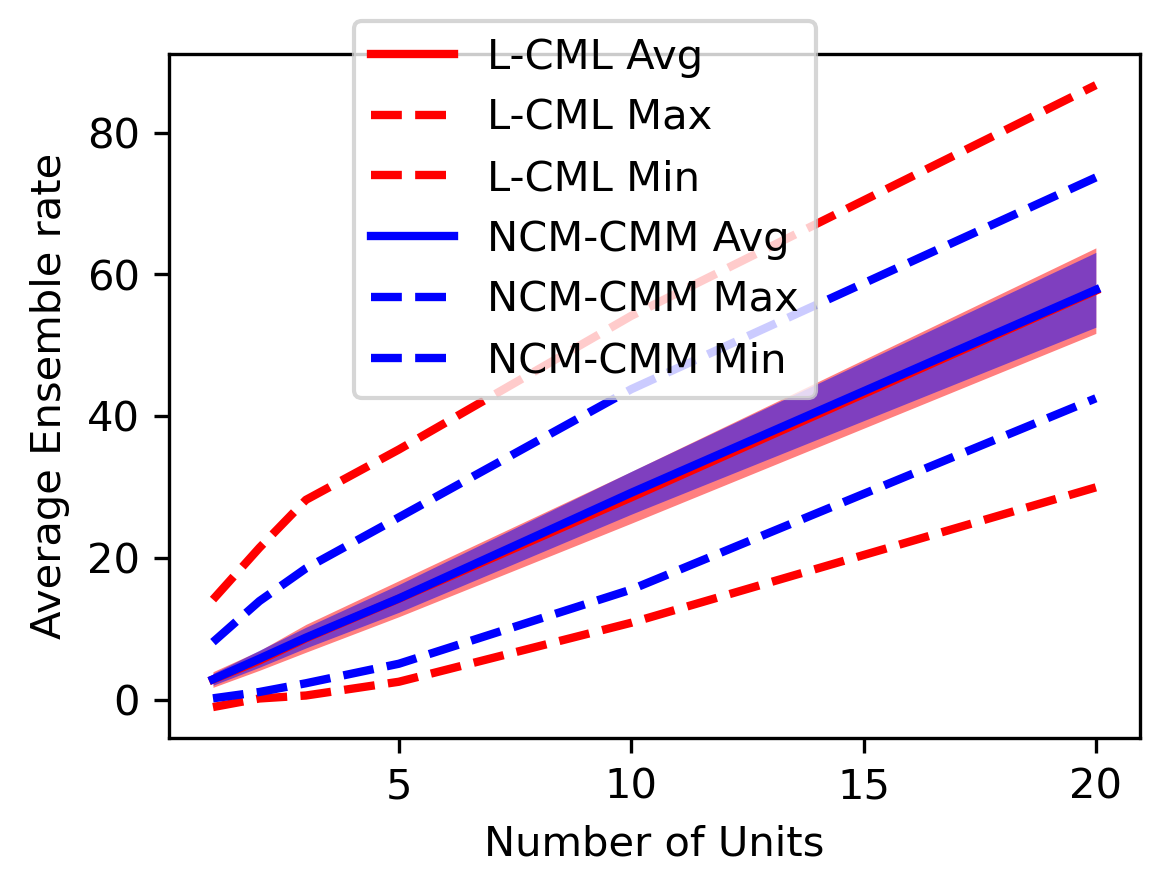

In [16]:
# Make plot of mean rate values
fig, ax1 = plt.subplots(figsize=(4, 3), dpi =300)

ax1.set_xlabel('Number of Units')
ax1.set_ylabel('Average Ensemble rate')
for izone, zone in enumerate(zoneUnique):
    ax1.plot(numUnits, rateMean[:,izone], color=colorName[izone], linestyle='-', linewidth=2, label=zone +' Avg')
    ax1.fill_between(numUnits, rateMean[:,izone] + 2*rateSD[:,izone]/np.sqrt(unitNumber[:,izone]-numUnits),
                               rateMean[:,izone] - 2*rateSD[:,izone]/np.sqrt(unitNumber[:,izone]-numUnits), 
                               alpha=0.5, linewidth=0, color = colorName[izone] )
    ax1.plot(numUnits, rateMax[:,izone], color=colorName[izone], linestyle='--', linewidth=2, label=zone +' Max')
    ax1.plot(numUnits, rateMin[:,izone], color=colorName[izone], linestyle='--', linewidth=2, label=zone +' Min')



fig.tight_layout()
fig.legend(loc='upper center')

plt.savefig('/Users/frederictheunissen/Desktop/RatevsUnitsvsArea.eps')


In [18]:
# Perform the statistical analysis for 20 units
from scipy.stats import t as tdist

diffMean = rateMean[5,0] - rateMean[5,1]
# I am going to use the equal variance assumption
nE = numUnits[5]
n0 = unitNumber[5][0]-nE+1
n1 = unitNumber[5][1]-nE+1
df = (n0 + n1 - 2)
pooledSD = np.sqrt( (rateSD[5,0]**2*(n0-1) + rateSD[5,1]**2*(n1-1)) / df)

tval = diffMean/(pooledSD*np.sqrt(1/n0 + 1/n1))
dval = diffMean/pooledSD

# Two tail t-test
pval = 2*(1 - tdist.cdf(abs(tval), df))

print('Rate d=', dval, 't(', df, ')=', tval, 'p=', pval)

Rate d= -0.007278124629864712 t( 54.0 )= -0.025787137568907253 p= 0.9795221824468212


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


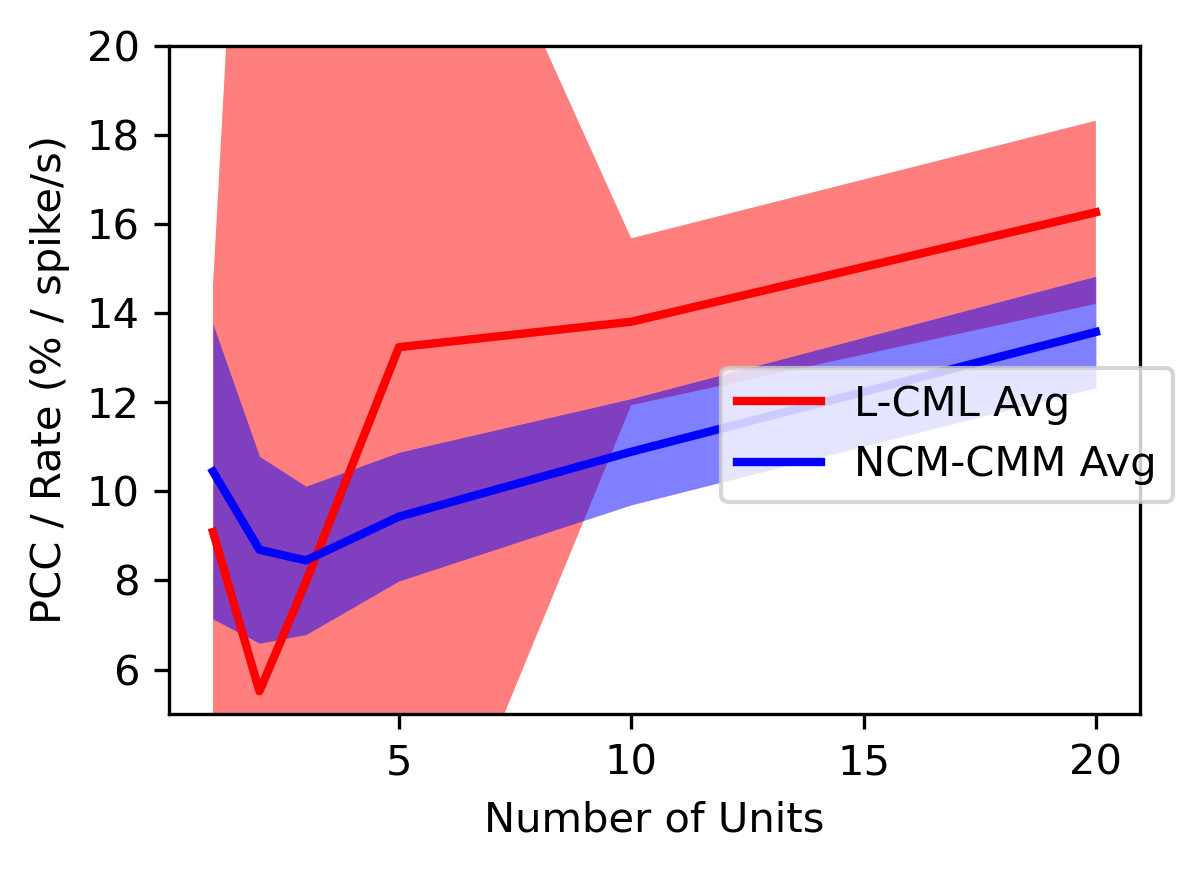

In [19]:
# Make plot of mean values
fig, ax1 = plt.subplots(figsize=(4, 3), dpi =300)

ax1.set_xlabel('Number of Units')
ax1.set_ylabel('PCC / Rate (% / spike/s)')

for izone, zone in enumerate(zoneUnique):
    ax1.plot(numUnits, pccNormMean[:,izone]*numUnits, color=colorName[izone], linestyle='-', linewidth=2, label=zone +' Avg')
    ax1.fill_between(numUnits, pccNormMean[:,izone]*numUnits + 2*pccNormSD[:,izone]*numUnits/np.sqrt(unitNumber[:,izone]-numUnits),
                               pccNormMean[:,izone]*numUnits - 2*pccNormSD[:,izone]*numUnits/np.sqrt(unitNumber[:,izone]-numUnits), 
                               alpha=0.5, linewidth=0, color = colorName[izone] )



ax1.set_ylim((5,20))
fig.tight_layout()
fig.legend(loc='center right')

plt.savefig('/Users/frederictheunissen/Desktop/PCCNormvsUnitsvsArea.eps')

In [20]:
# Perform the statistical analysis for 20 units
from scipy.stats import t as tdist

diffMean = pccNormMean[5,0] - pccNormMean[5,1]
# I am going to use the equal variance assumption
nE = numUnits[5]
n0 = unitNumber[5][0]-nE+1
n1 = unitNumber[5][1]-nE+1
df = (n0 + n1 - 2)
pooledSD = np.sqrt( (pccNormSD[5,0]**2*(n0-1) + pccNormSD[5,1]**2*(n1-1)) / df)

tval = diffMean/(pooledSD*np.sqrt(1/n0 + 1/n1))
dval = diffMean/pooledSD

# Two tail t-test
pval = 2*(1 - tdist.cdf(abs(tval), df))

print('PCC Norm d=', dval, 't(', df, ')=', tval, 'p=', pval, 'n0=', n0, 'n1=', n1)

PCC Norm d= 0.5102814518368356 t( 54.0 )= 1.8079792070863172 p= 0.07618013495179365 n0= 37.0 n1= 19.0


In [18]:
unitNumber[5][1]

38.0

In [42]:
outPath = rootPath+dataPath+'pccUnitRateArea.pkl'
fileOut = open(outPath,"wb")
pk.dump(argList, fileOut)
pk.dump(pcc, fileOut)
pk.dump(selH, fileOut)
pk.dump(rate, fileOut)
pk.dump(pccNorm, fileOut)


fileOut.close()